# Advanced Data Science for MPS

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from load_data_common import load_data
import seaborn as sns
import math

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'

## Import MPS data

In [2]:
path_to_data = Path("data_curated")
for p in path_to_data.iterdir():
    print(p)
    
df_features = pd.read_csv(path_to_data.joinpath("features.csv"), index_col=0)
df_features.replace(["0nM", "0uM"], "baseline", inplace=True)
df_features.sort_values(["drug", "experiment", "well", "tissue", "dose"], ascending=[True, True, True, True, False], inplace=True)
drop_rows = np.where(pd.isnull(df_features["voltage_apd30"])|
                     pd.isnull(df_features["voltage_apd90"])|
                     pd.isnull(df_features["voltage_beating_frequencies"])
                    )
df_features.drop(index=df_features.iloc[drop_rows].index.tolist(), inplace=True)
df_features.reset_index(drop=True, inplace=True)

df_traces = pd.read_csv(path_to_data.joinpath("traces_avg.csv"), index_col=0)

cols_array = ["voltage_time", "voltage_trace",
              "calcium_time", "calcium_trace",
              "displacement_time", "displacement_trace",
              "velocity_time", "velocity_trace"]

for col_name in cols_array:
    df_traces[col_name] = df_traces[col_name].apply(eval)
    df_traces[col_name] = df_traces[col_name].apply(lambda x: np.array(x, dtype=np.float32))

print(f"Number of items: {df_features.shape[0]}")

# convert dose strings to float
unit_dict = {"baseline":0.0,
             '0.1nM':0.1e-9, '1nM':1e-9, '10nM':10e-9, '100nM':100e-9, '1000nM':1000e-9, '10000nM':10000e-9,
             '3nM':3e-9, '30nM':30e-9, '300nM':300e-9, '3000nM':3000e-9,
             '3uM':3e-6, '30uM':30e-6, '0.3uM':0.3-6, '300uM':300e-6,
             '1uM':1e-6, '10uM':10e-6, '100uM':100e-6, '0.1uM':0.1e-6,
             '0.6%':0.0, '0.06%':0.0, '0.006%':0.0, '0.0006%':0.0
            }

df_features.insert(loc=5, column="dose_float", value=[unit_dict[d] for d in df_features["dose"]])

data_curated/traces_full.csv
data_curated/traces_avg.csv
data_curated/features.csv
Number of items: 484


In [110]:
print(df_features.columns)

Index(['drug', 'experiment', 'well', 'tissue', 'dose', 'dose_float',
       'voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
       'voltage_beating_frequencies', 'voltage_beating_frequency',
       'voltage_capd30', 'voltage_capd50', 'voltage_capd80', 'voltage_capd90',
       'voltage_dFdt_max', 'voltage_int30', 'voltage_num_beats',
       'voltage_num_eads', 'voltage_slope_APD80', 'voltage_slope_cAPD80',
       'voltage_tau75', 'voltage_triangulation', 'voltage_ttp',
       'voltage_upstroke80', 'calcium_apd30', 'calcium_apd50', 'calcium_apd80',
       'calcium_apd90', 'calcium_beating_frequencies',
       'calcium_beating_frequency', 'calcium_capd30', 'calcium_capd50',
       'calcium_capd80', 'calcium_capd90', 'calcium_dFdt_max', 'calcium_int30',
       'calcium_num_beats', 'calcium_num_eads', 'calcium_slope_APD80',
       'calcium_slope_cAPD80', 'calcium_tau75', 'calcium_triangulation',
       'calcium_ttp', 'calcium_upstroke80',
       'brightfield_Max contract

In [12]:
features_of_interest = ['voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
                       'calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'calcium_apd90',
                       'brightfield_Max contraction velocity [μm/s]', 'brightfield_Max relaxation velocity [μm/s]',
                       'brightfield_Time between contraction and relaxation [ms]',
                       'brightfield_Width at half height (displacement)[ms]']

# find unique rows based on columns
filter_names = ["drug", "well", "tissue"]
dff = df_features[filter_names].drop_duplicates()

df_norm = df_features.copy()

idxs_drop = []
for row in dff.itertuples():
    idxs = np.where((df_norm["drug"] == row.drug) & (df_norm["well"] == row.well) & (df_norm["tissue"] == row.tissue))[0]
    try:
        idx_bl = np.where((df_norm["drug"]==row.drug) & (df_norm["well"]==row.well) & (df_norm["tissue"]==row.tissue) & (df_norm["dose"]=="baseline"))
        a = df_norm[features_of_interest].iloc[idxs].values   # dosed values
        b = df_norm[features_of_interest].iloc[idx_bl].values # baseline values
        df_norm.loc[idxs, features_of_interest] = np.divide(a, b)
    except:
        for i in idxs: idxs_drop.append(i)
        continue
df_norm.drop(idxs_drop, inplace=True)
df_norm.reset_index(drop=True, inplace=True)


Filter dataframe by drug

In [67]:
df_CisD7 = df_features[
    (df_features["drug"].values == "Cisapride")&(df_features["well"].values == "D7")
    ]

## Import drug summary table

In [5]:
file_path = Path("drug_summary_ordinal.csv")

df_drug = pd.read_csv(file_path)

key_ordinal = {0:"no effect",
               1:"mild increase",
               2:"strong increase",
               3:"mild decrease",
               4:"strong decrease"}

key_binary = {0:"no effect",
              1:"observed"}

In [6]:
drug_mechanism = {
    "omecamtiv":"TnC agonist",
    "Nifedipine":"L-type Ca block",
    "Verapamil":"L-type Ca block, hERG block",
    "Bay_K":"L-type Ca block",
    "Dofetilide":"hERG block",
    "Flecainide":"Fast Na block, hERG block, RyR block",
    "Digoxin":"Na-K ATPase",
    "dobutamine":"beta adrenergic blocker",
    "carvedilol":"beta adrenergic blocker",
    "blebbistatin":"myosin ATPase blocker",
    "levosimendan":"potassium modulation, TnC agonist",
    "milrinone":"beta adrenergic agonist",
    "Isoproterenol":"beta adrenergic agonist",
    "Alfuzosin":"alpha adrenergic block",
    "Bepridil":"multi channel block",
    "Cisapride":"hERG block",
    "Terfenadine":"H1 receptor agonist",
    "Control":"NA", 
    "aspirin":"NA"
}

mechanism_list = list(set(drug_mechanism.values()))
mechanism_class = {
    mech:idx for mech,idx in zip(mechanism_list, range(len(mechanism_list)))
}
print(f"Number of drug classes = {len(mechanism_class)}")

Number of drug classes = 14


In [7]:
# check drugs are in drug_mechanism
data_drugs = list(set(df_features.drug))
check = np.any([d not in drug_mechanism for d in data_drugs])
if check:
    print("Oops! Some drugs from data are not in the drug mechanism list!")
else:
    print("Looks good! All drugs are in list.")

Looks good! All drugs are in list.


## Unsupervised clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [32]:
# Evaluate the variablitiy of baseline dose across all tissues and wells:
# This establishes whether we need to do a paired effect as input or simply 
# use the values at multiple doses

df_baseline = df_features[
    (df_features["dose"].values == "baseline")
]

apd80_baseline_mean = df_baseline["calcium_apd80"].mean()
apd80_baseline_std = df_baseline["calcium_apd80"].std()

print(f"{apd80_baseline_mean = } ± {apd80_baseline_std}")

apd80_baseline_mean = 560.4204014581281 ± 70.27943875522786


In [38]:
# my_features = ["dose_float", "voltage_apd30", "voltage_apd60", "voltage_apd80", "voltage_apd90"]
my_features = features_of_interest

df_X = df_norm[(df_norm["dose"]!="baseline")].dropna(inplace=False)
X = df_X.loc[:, my_features]
print(f"Number of data points = {len(X)}")

n_clusters = 14
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
X_tf = kmeans.transform(X)

Number of data points = 267


***
Now we compare the real drug name and class of mechanism to the assigned cluster labels
***

In [44]:
drug_as_mechanism_class = [mechanism_class[drug_mechanism[d]] for d in df_X["drug"].values]
compare = [[d, mc, cc] for d,mc,cc in zip(df_X["drug"].values, drug_as_mechanism_class, kmeans.labels_)]

cluster_centers = kmeans.cluster_centers_
cluster_dist = {f"dist_c{i}":X_tf[:,i] for i in range(n_clusters)}

data = {"drug":df_X["drug"], 
        "mechanism":[drug_mechanism[d] for d in df_X["drug"].values],
        "mechanism_class":drug_as_mechanism_class,
        "kmeans_label":kmeans.labels_
       }
data = {**data, **cluster_dist}

df_kmeans = pd.DataFrame(data=data)

In [128]:
# Calculate distance between each cluster center
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])

Plot the frequency of each cluster for each drug

<Axes: xlabel='kmeans_label', ylabel='drug'>

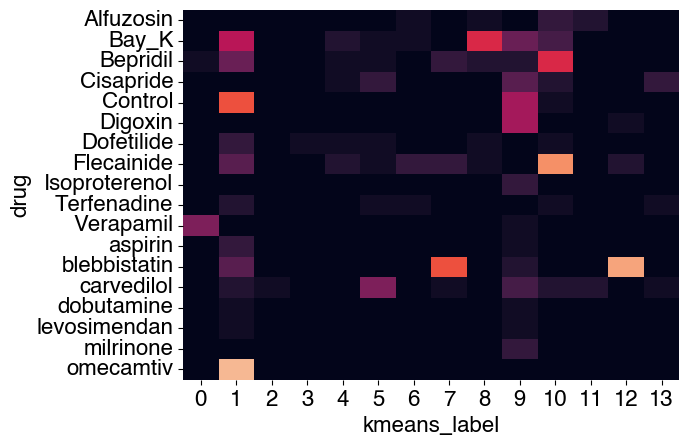

In [126]:
test = pd.crosstab(df_kmeans["drug"], df_kmeans["kmeans_label"])
sns.heatmap(data=test,
           vmin=0,
           vmax=22,
           xticklabels=True,
           yticklabels=True,
           cbar=False)

Plot the distance between each cluster center

Text(0.5, 1.0, 'Distance between kmeans clusters')

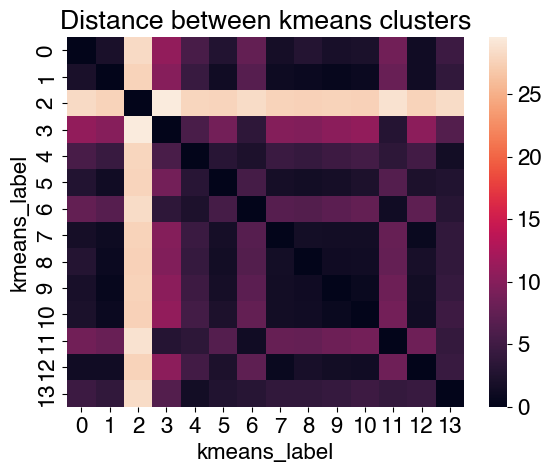

In [133]:
# Calculate distance between each cluster center
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])
        
g = sns.heatmap(cluster_dist_2d)
g.set_xlabel("kmeans_label")
g.set_ylabel("kmeans_label")
g.set_title("Distance between kmeans clusters")

In [ ]:

plt.figure(figsize=(12,5))
g = sns.violinplot(data=df_kmeans,
                   x="drug",
                   y="kmeans_label",
                   scale="width",
                   bw=0.2
                   # hue="kmeans_label"
                 )
g.set_xticklabels(g.get_xticklabels(), rotation=45);

***
Examine cluster centers to see if 

## Dimensionality reduction

In [ ]:
# Dim reduction here

## Supervised learning

Unsupervised clustering is a great way to identify groups in data in an unbiased way, the goal of which is to see if data is naturally separable in a meaningful way.

Supervised learning has a different goal: We seek to classify new data based on what we know about existing data.